In [1]:
#setup
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
from IPython.display import display
from unidecode import unidecode
from gensim.corpora import Dictionary

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set_theme()
plt.rcParams["figure.figsize"] = (10,8)
pd.options.mode.chained_assignment = None #disable a specific warning

# Creating the csv

In [2]:
from main import nlp_pipeline_result

# data = nlp_pipeline_result(
#     parser_parameters={
#         "remove_hashtag_word": True,
#         "replace_politics": True,
#         "replace_parties": True,
#     },
#     nlp_parameters={
#         "disable_parser": True,
#         "disable_ner": True
#     }
# )
# data['n_lemmas'] = data['Lemmas'].str.split().str.len()
# 
# data.to_csv('data/data.csv', index = False)

# Spliting train and test

In [3]:
data = pd.read_csv('data/data.csv')

train = data.sample(frac=0.8, random_state=420)
test = data.drop(train.index)
data = train

print(f"Len data: {len(data)}")
print(f"Len train: {len(train)}")
print(f"Len test: {len(test)}")

Len data: 11850
Len train: 11850
Len test: 2962


# Parsing Lemmas

In [4]:
def remove_accents(sentence):
    parsed_sentence = []
    for word in sentence.split(" "):
        if "ñ" in word:
            parsed_sentence.append(word)
        else:
            parsed_sentence.append(unidecode(word))
    return " ".join(parsed_sentence)

In [5]:
data['Lemmas'] = data['Lemmas'].apply(lambda x: remove_accents(str(x).lower()))

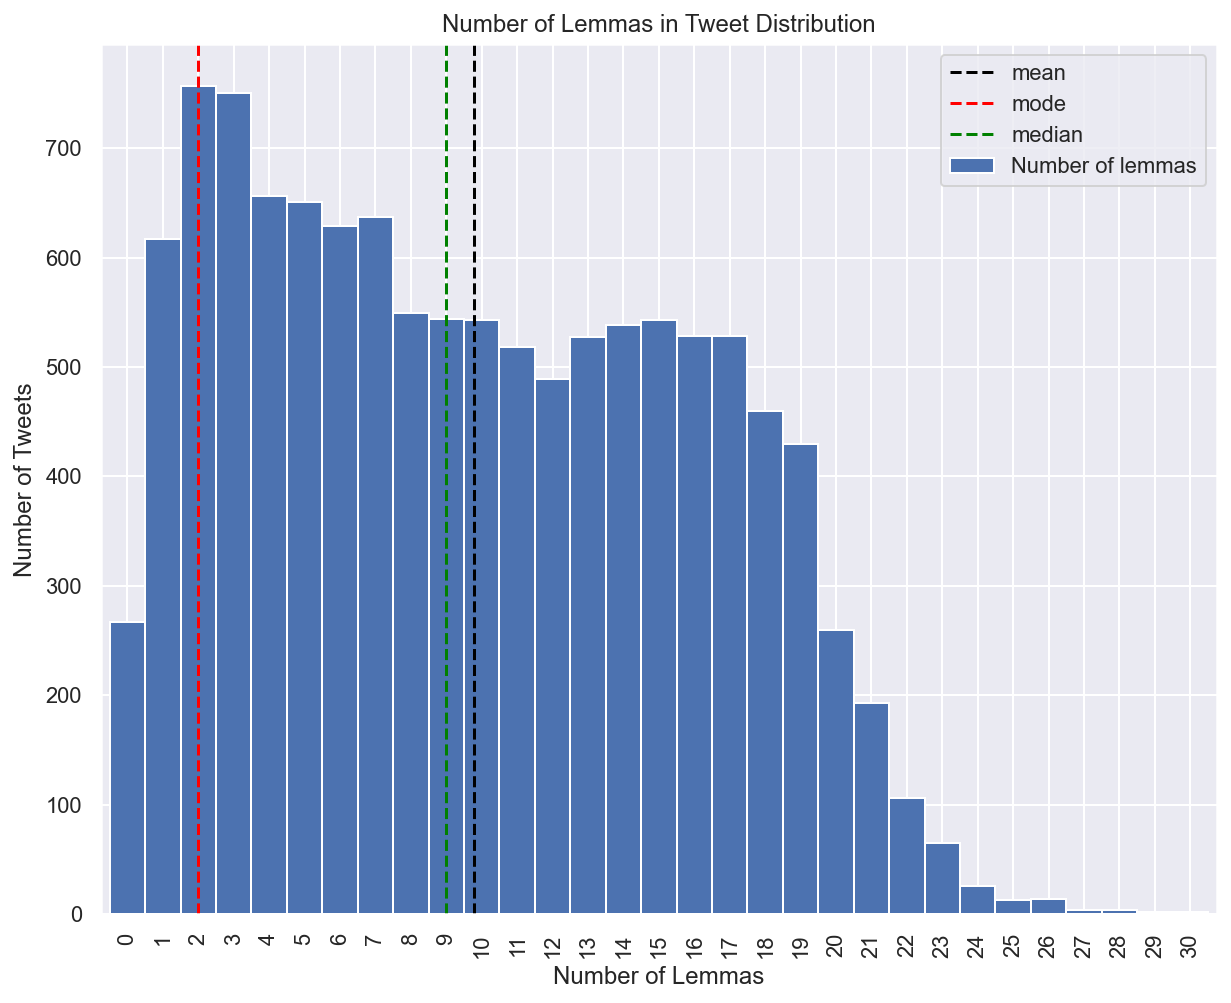

In [6]:
plt.figure()
data['n_lemmas'].value_counts().sort_index().plot(kind="bar", width=1, label='Number of lemmas')
plt.axvline(x=data['n_lemmas'].mean(),
            label='mean', color='black',
            linestyle = '--')
plt.axvline(x=data['n_lemmas'].mode()[0],
            label='mode', color='red',
            linestyle = '--')
plt.axvline(x=data['n_lemmas'].median(),
            label='median', color='green',
            linestyle = '--')
plt.legend()
plt.title('Number of Lemmas in Tweet Distribution')
plt.xlabel('Number of Lemmas')
plt.ylabel('Number of Tweets')
plt.show()

In [7]:
data = data[data['n_lemmas'] >= 3]
print(f'Number of Tweets in Dataframe after removing short tweets: {len(data)}')

Number of Tweets in Dataframe after removing short tweets: 10209


# Creating the Corpus and Dictionary of terms

In [8]:
def from_df_to_token_dictionary (df, n_lemmas_threshold=3):
    
    df = df[df['n_lemmas'] >= n_lemmas_threshold]
    print(f'Number of Tweets in Dataframe after removing short tweets: {len(df)}')
    
    tweets_corpus = [el.split() for el in df["Lemmas"]]
    # display(tweets_corpus)
    
    token_dic = Dictionary(tweets_corpus)
    return token_dic, tweets_corpus

In [9]:
token_dict, tweets_corpus = from_df_to_token_dictionary(data, n_lemmas_threshold=3)

Number of Tweets in Dataframe after removing short tweets: 10209


In [10]:
def create_word_freq(token_dic):
    word_freq = {}
    for k, v in token_dic.items():
        word_freq[v] = token_dic.cfs[k]

    sorted_word_freq = dict(sorted(word_freq.items(), key=lambda item: item[1], reverse=True))
    
    return sorted_word_freq

In [11]:
sorted_word_freq = create_word_freq(token_dict)
# print(sorted_word_freq)

# Plot and analysis of term Dictionary stuff

In [12]:
def plot_frequencies(collection):
    collfreq = sorted(collection.items()) 
    x, y = zip(*collfreq) 
    plt.plot(x, y)

In [13]:
def compute_token_mean_max(collection):
    count, _sum = 0, 0
    for key in collection:
        count += 1
        _sum += collection[key]
    
    instances_max = max(collection.values())
    instances_mean = _sum/count
    
    return instances_max, instances_mean

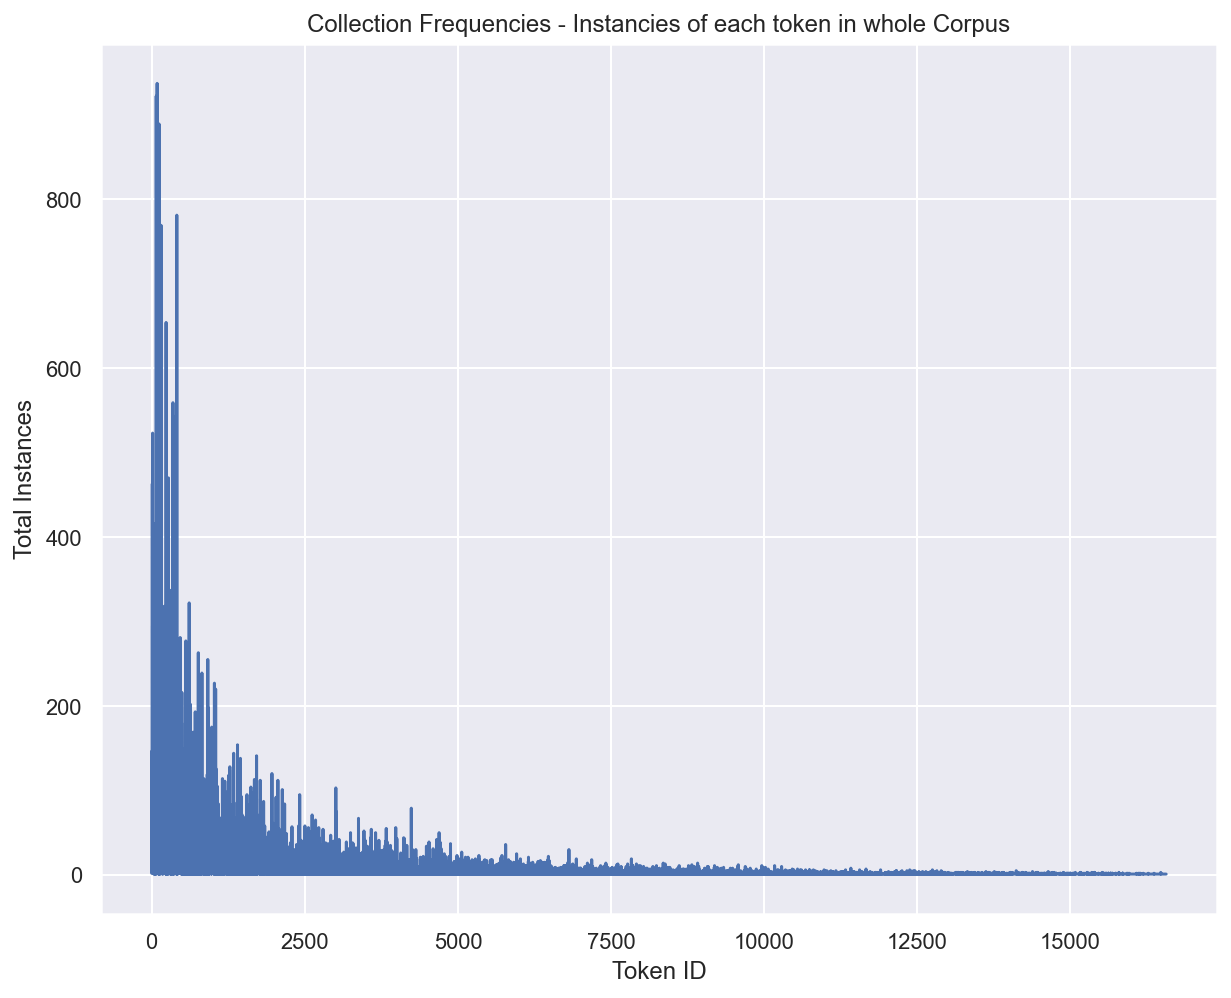

Max of occurances per topic: 937
Mean of occurances per topic: 6.8694680915293125


In [14]:
# Collection frequencies: token_id -> how many instances of this token are contained in the documents.
plot_frequencies(token_dict.cfs)
plt.title('Collection Frequencies - Instancies of each token in whole Corpus')
plt.xlabel('Token ID')
plt.ylabel('Total Instances')
plt.show()

instances_max, instances_mean = compute_token_mean_max(token_dict.cfs)

print(f"Max of occurances per topic: {instances_max}")
print(f"Mean of occurances per topic: {instances_mean}")

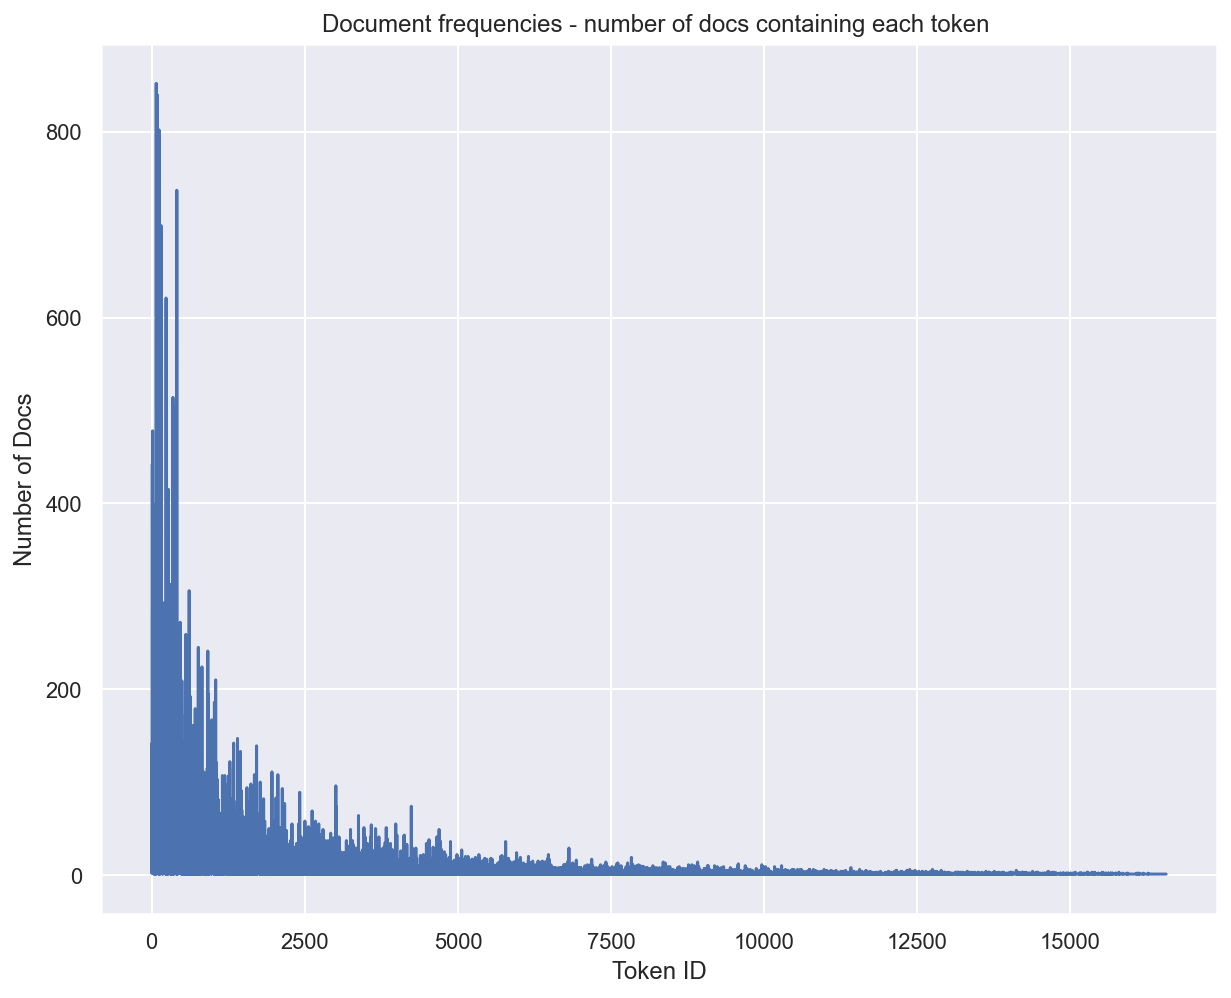

Max of docs in which a token appears: 852
Mean of docs in which token appears: 6.622532149972831


In [15]:
# Document frequencies: token_id -> how many documents contain this token
plot_frequencies(token_dict.dfs)
plt.title('Document frequencies - number of docs containing each token ')
plt.xlabel('Token ID')
plt.ylabel('Number of Docs')
plt.show()

docs_max, docs_mean = compute_token_mean_max(token_dict.dfs)

print(f"Max of docs in which a token appears: {docs_max}")
print(f"Mean of docs in which token appears: {docs_mean}")

# Choosing hyperparameters for filtering extremes

In [16]:
def filter_dict_and_get_bow(token_dict, corpus, below=2, above=1):
    copy_dict = copy.copy(token_dict)
    copy_dict.filter_extremes(no_below=below, no_above=above)
    bow = [copy_dict.doc2bow(doc) for doc in corpus]
    return copy_dict, bow

In [17]:
#FILTER TOKEN DICTIONARY

no_below_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] #Minimum number of documents to keep a term in the dictionary
no_above_list = [.5, .4, .3, .2, .05, .04, .03, .02, .005, .004, .003, .002, .0005, .0004, 0.0003, .0002] #Maximum proportion of documents in which a term can appear to be kept in the dictionary

# prev_tokens = len(token_dict)

# print('The dictionary contained', prev_tokens, 'terms')

# for i in no_below_list:
#     for j in no_above_list:
#         token_dic = Dictionary(tweets_corpus)
#         token_dic.filter_extremes(no_below=i,no_above=j)
#         n_tokens = len(token_dic)
        
#         print(n_tokens, 'terms |no_below = ', i, "| no_above = ", j)

#print('First terms in the dictionary:')
#for n in range(500):
#    print(str(n), ':', token_dic[n])#FILTER TOKEN DICTIONARY

# Obtaining BOW from filtered Dictionary

In [18]:
# BOW: Transform list of tokens into list of tuples (token id, token # of occurrences)
# filtered_dict = copy.copy(token_dict)

# filtered_dict = filter_dict(token_dict)
# tweets_bow = get_bow(token_dict, tweets_corpus)
filtered_dict, tweets_corpus_bow = filter_dict_and_get_bow(token_dict, tweets_corpus)

print(f'The dictionary contains {len(filtered_dict)} terms')

The dictionary contains 7270 terms


# Applying LDA and Ploting it for visualization of terms in topics

In [19]:
import os
from gensim.models.wrappers import LdaMallet

os.environ['MALLET_HOME'] = r'C:/mallet'
mallet_path = 'C:/mallet/bin/mallet'
# mallet_path = '/Users/bernardobouzas/Downloads/mallet-2.0.8/bin/mallet'

In [20]:
def compute_lda(corpus, token_dict, num_topics=15, alpha=5, iterations=100):
    ldamallet = LdaMallet(
        mallet_path,
        corpus=corpus,
        id2word=token_dict,
        num_topics=num_topics,
        alpha=alpha,
        iterations=iterations
    )
    return ldamallet

In [21]:
ldamallet = compute_lda(tweets_corpus_bow, filtered_dict, num_topics=15)

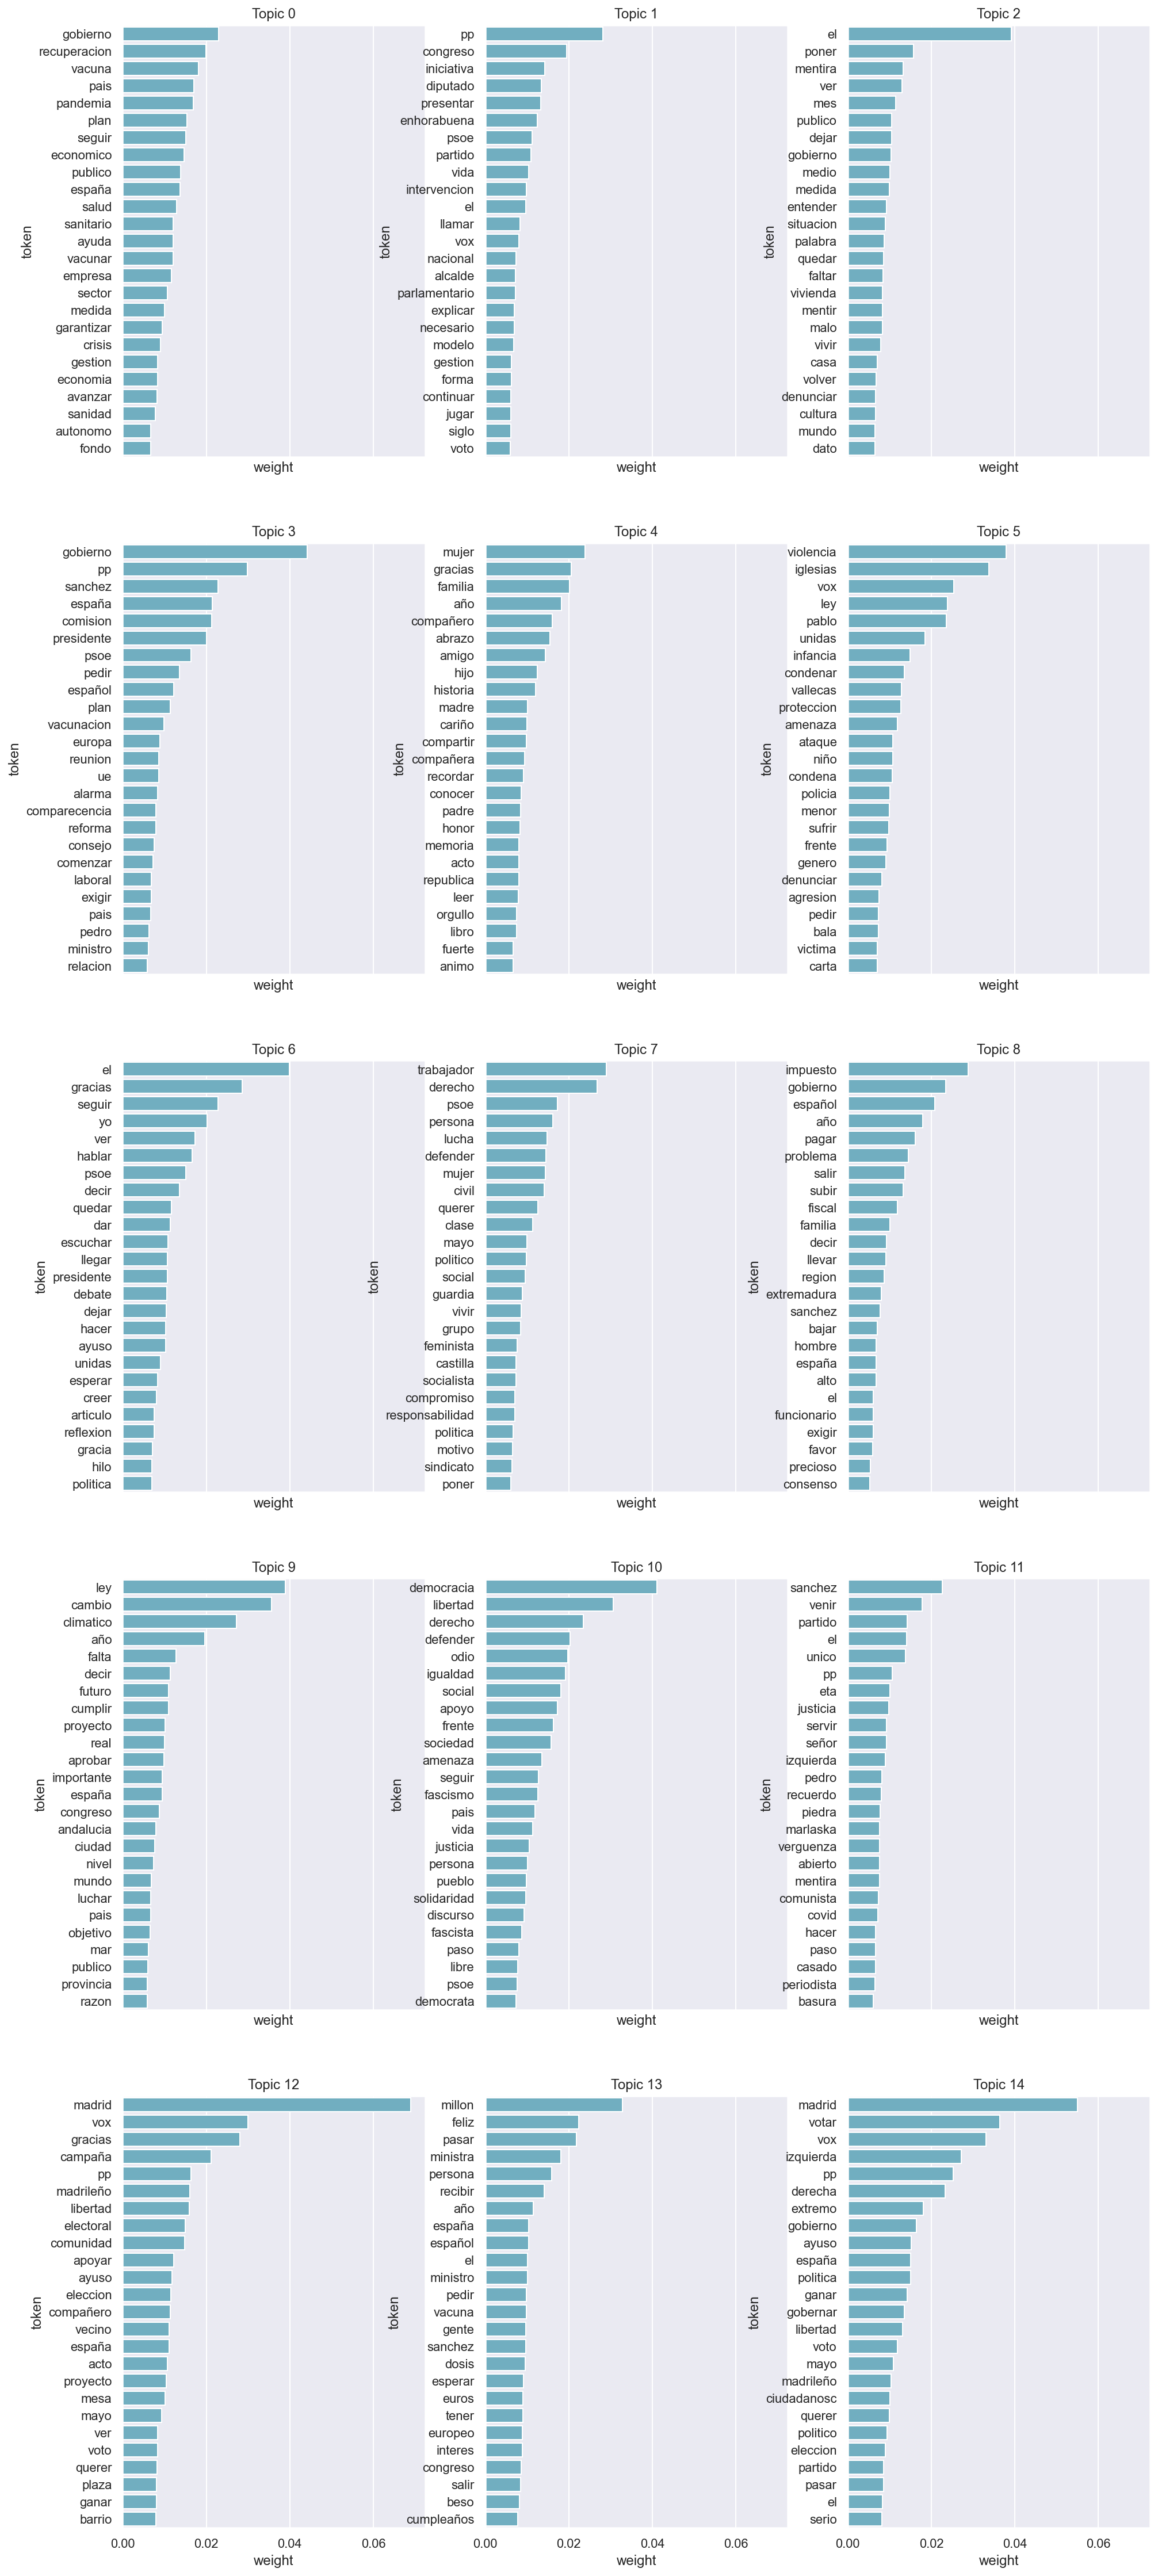

In [22]:
topn = 25
rows, cols = 5, 3
fig, axes = plt.subplots(rows, cols, figsize=(16, 40), sharex=True)

for i in range(rows):
    for j in range(cols):
        df = pd.DataFrame(ldamallet.show_topic(j + cols*(i%rows), topn=topn), columns=['token','weight'])
        sns.barplot(x='weight', y='token', data=df, color='c', orient='h', ax=axes[i][j])
        axes[i][j].set_title(f'Topic {j + cols*(i%rows)}')

plt.show()

# Specific stopword removal

In [23]:
specific_stw = [
    'el', 'año', 'vivir', 'hacer', 'plan',
    'sector', 'salir', 'gestion', 'resto',
    'ir', 'yo', 'ley', 'gobierno', 'serio',
    'nacional', 'acto', 'minuto', 'explicar',
    'estar', 'poner', 'discurso', 'pedir',
    'volver', 'alto', 'punto', 'pasar', 'pais',
    'dar', 'quedar', 'hablar', 'decir', 'dejar',
    'ver', 'paso', 'importante', 'aprobar', 'gente',
    'dato', 'llegar', 'politica', 'venir', 'leer',
    'seguir', 'entender', 'tener', 'llevar', 'convertir',
    'directo', 'partido', 'cara', 'caso', 'hilo', 'gracia',
    'favor', 'medio', 'forma', 'señor', 'empezar',
    "psoe", "pp", "vox", "ciudadanos", "unidas",
    "angel","pablo", "pedro",
    "isabel", "español", "gracias", "españa"
]

# "gracias", "madrid", "españa"

# specific_stw = ["psoe", "pp", "vox", "ciudadanos", "unidas"]

specific_stw = list(set([el.lower() for el in specific_stw]))

In [24]:
def remove_stpwrd(string, specific_stw_eliminate):
    splitted = string.split()
    resultwords = [word for word in splitted if word.lower() not in specific_stw_eliminate]
    return ' '.join(resultwords)

In [25]:
data['Lemmas'] = data['Lemmas'].apply(lambda x: remove_stpwrd(str(x), specific_stw))

data['n_lemmas'] =  data['Lemmas'].str.split().str.len()
#print('Number of projects in DataFrame after applying specific stopwords and removing short texts:', len(NSF_df))

# Checking filtered results

Number of Tweets in Dataframe after removing short tweets: 9780


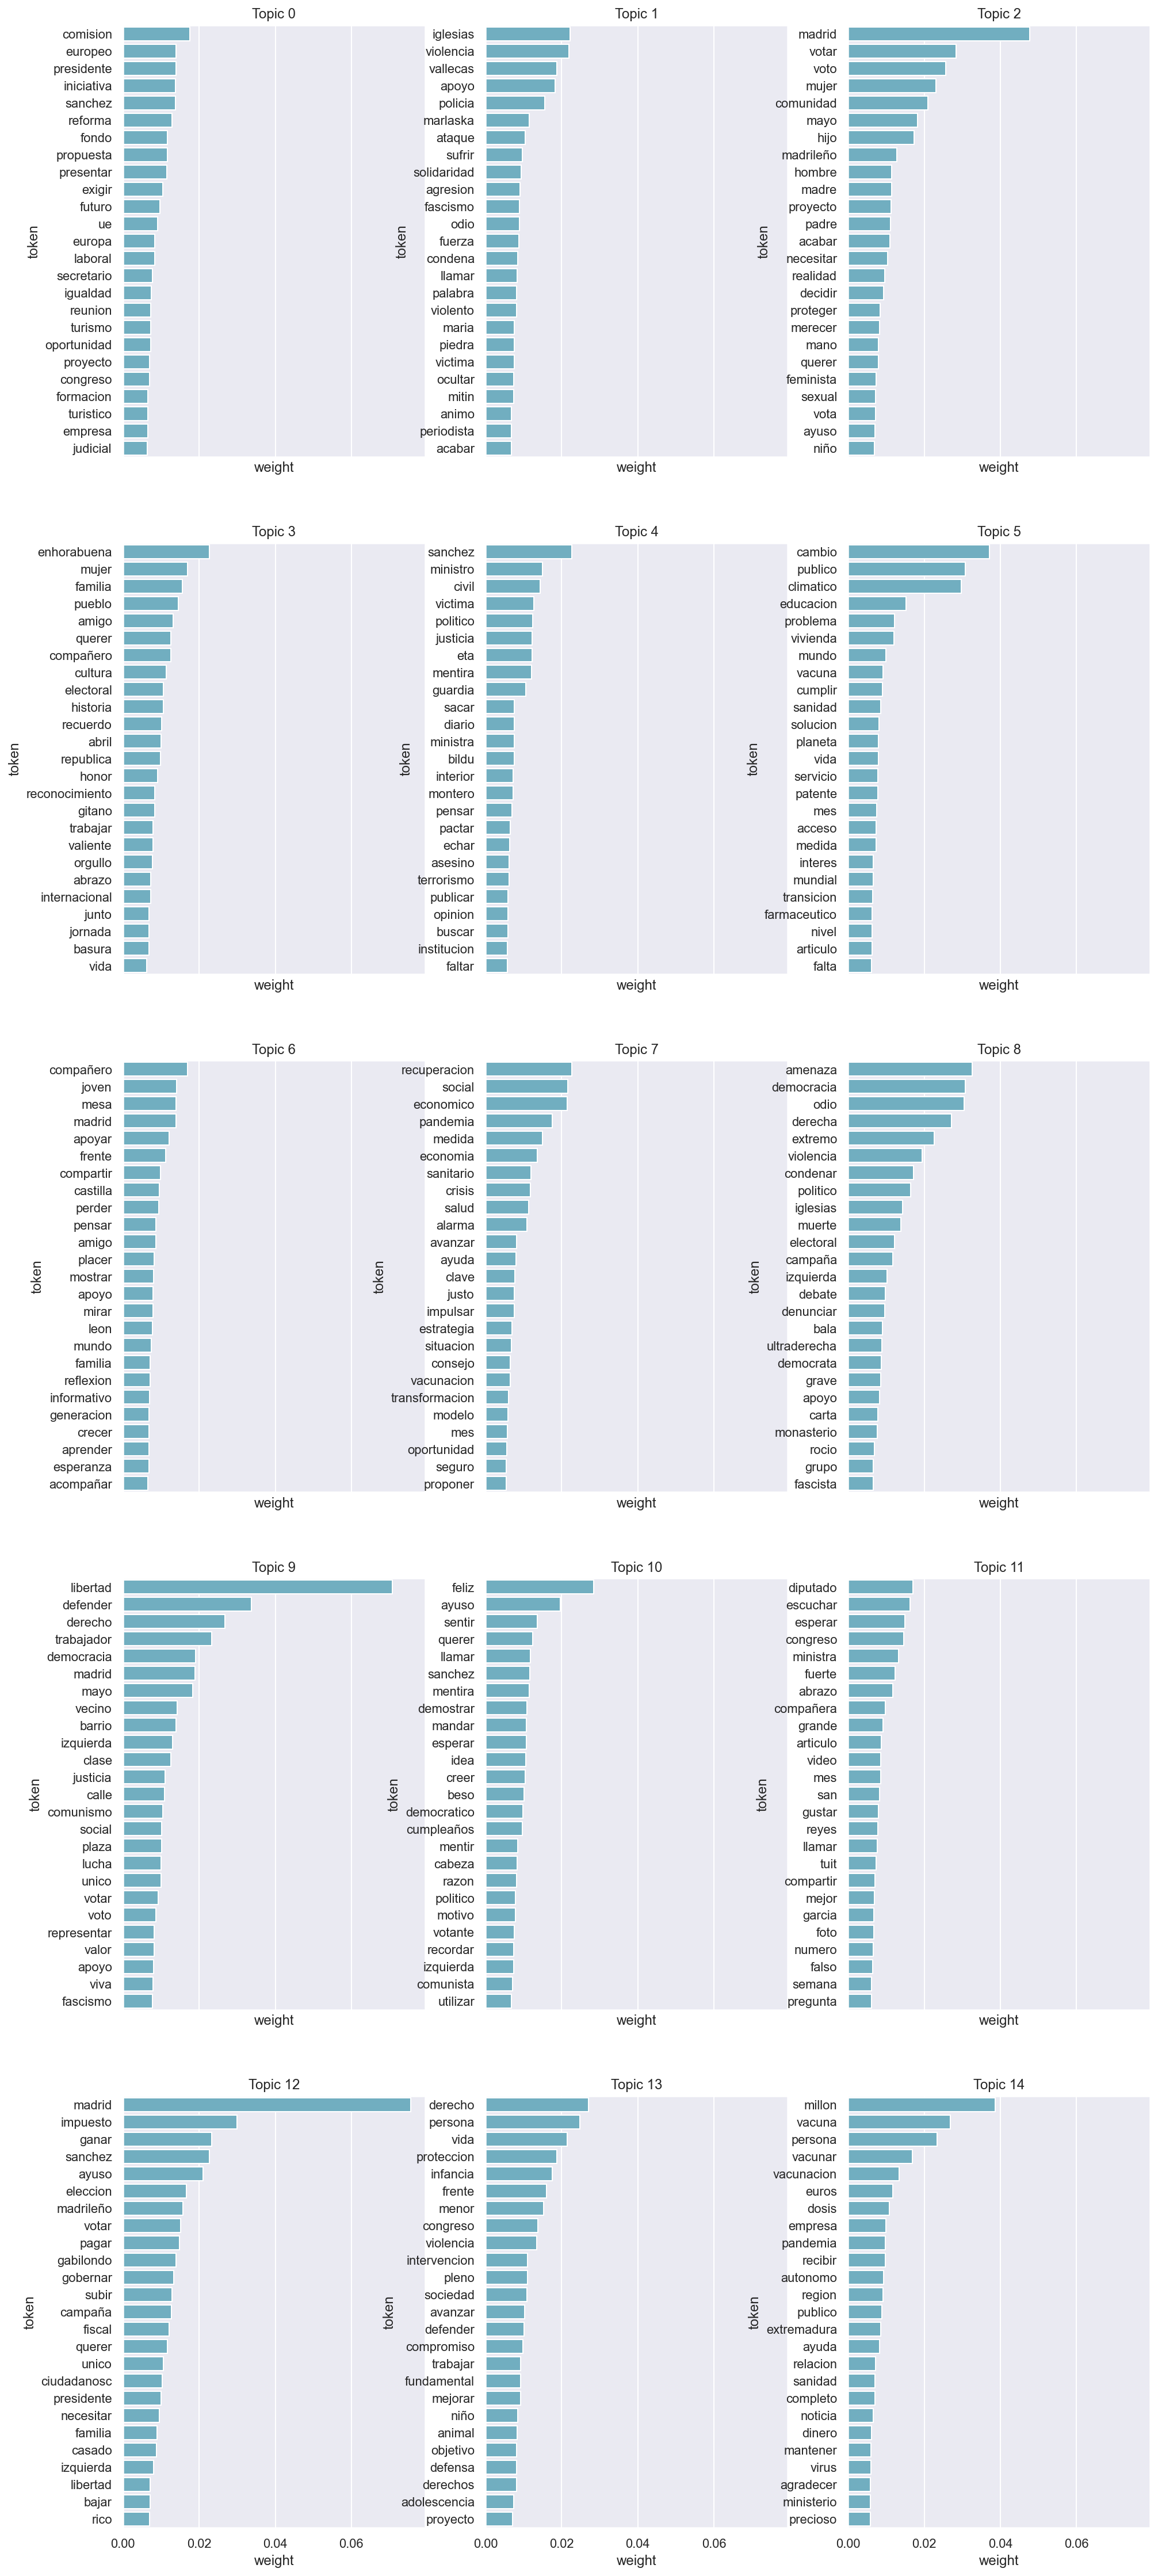

In [26]:
token_dict, tweets_corpus = from_df_to_token_dictionary(data, n_lemmas_threshold=3)
filtered_dict, tweets_corpus_bow = filter_dict_and_get_bow(token_dict, tweets_corpus)
ldamallet = compute_lda(tweets_corpus_bow, filtered_dict, num_topics=15)
topn = 25
rows, cols = 5, 3
fig, axes = plt.subplots(rows, cols, figsize=(16, 40), sharex=True)

for i in range(rows):
    for j in range(cols):
        df = pd.DataFrame(ldamallet.show_topic(j + cols*(i%rows), topn=topn), columns=['token','weight'])
        sns.barplot(x='weight', y='token', data=df, color='c', orient='h', ax=axes[i][j])
        axes[i][j].set_title(f'Topic {j + cols*(i%rows)}')

plt.show()

# Choosing hyperparameter number of topics

In [27]:
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel

In [28]:
token_dict, tweets_corpus = from_df_to_token_dictionary(data, n_lemmas_threshold=3)
filtered_dict, tweets_corpus_bow = filter_dict_and_get_bow(token_dict, tweets_corpus)

Number of Tweets in Dataframe after removing short tweets: 9780


In [29]:
def compute_lda_coherence(corpus, corpus_bow, token_dict, min_topics=10, max_topics=120, step=10):
    
    topic_coherence = []
    for ntpc in range(min_topics, max_topics + 1, step):
        lda_ntcp = LdaModel(corpus=corpus_bow, id2word=token_dict, num_topics=ntpc)
        topic_coherence.append(
            CoherenceModel(
                lda_ntcp,
                texts=corpus,
                dictionary=token_dict,
                coherence='c_v').get_coherence()
        )
        print(f'Computed model with {ntpc} topics out of {max_topics//step}')
    
    return topic_coherence

Computed model with 5 topics out of 10
Computed model with 20 topics out of 10
Computed model with 35 topics out of 10
Computed model with 50 topics out of 10
Computed model with 65 topics out of 10
Computed model with 80 topics out of 10
Computed model with 95 topics out of 10
Computed model with 110 topics out of 10
Computed model with 125 topics out of 10
Computed model with 140 topics out of 10


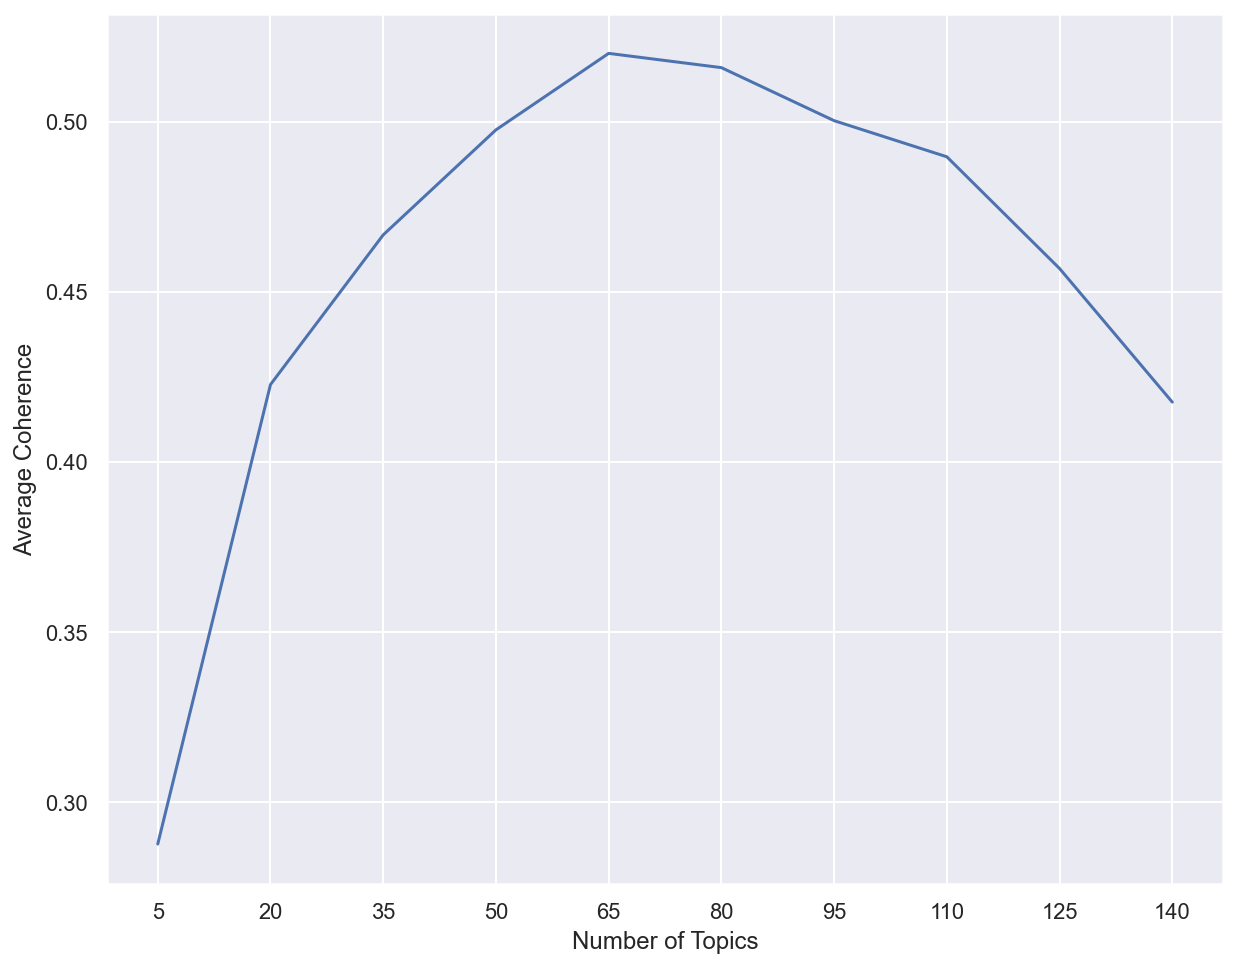

In [30]:
topic_coherence = compute_lda_coherence(tweets_corpus, tweets_corpus_bow, filtered_dict, 5,150,15)

n_topics = range(5, 150, 15)
plt.figure()
plt.plot(n_topics, topic_coherence)
plt.xticks(n_topics, n_topics)
plt.xlabel('Number of Topics')
plt.ylabel('Average Coherence')
plt.show()

Computed model with 3 topics out of 6
Computed model with 7 topics out of 6
Computed model with 11 topics out of 6
Computed model with 15 topics out of 6
Computed model with 19 topics out of 6
Computed model with 23 topics out of 6


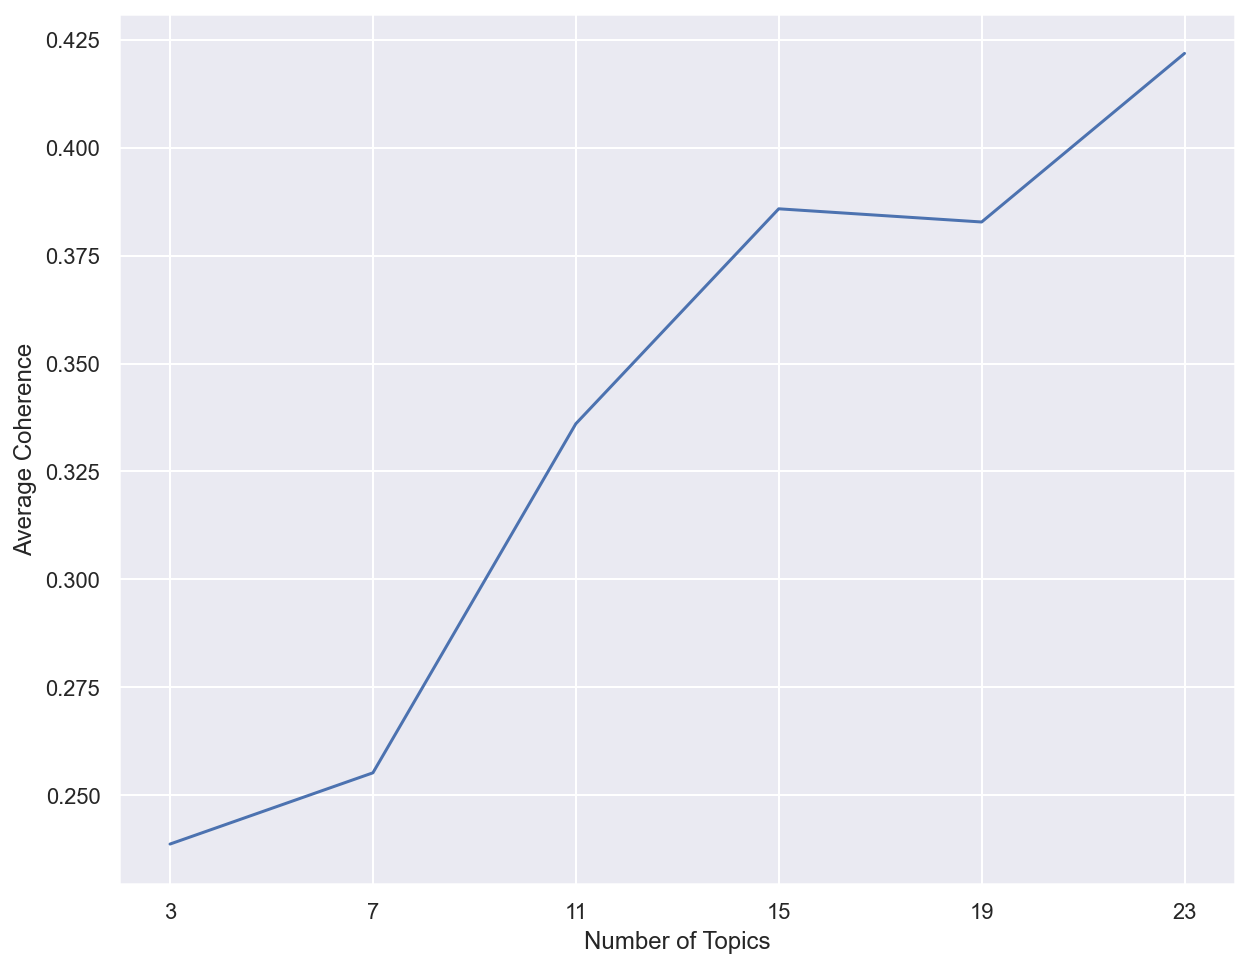

In [31]:
topic_coherence = compute_lda_coherence(tweets_corpus, tweets_corpus_bow, filtered_dict, 3,25,4)

n_topics = range(3, 25, 4)
plt.figure()
plt.plot(n_topics, topic_coherence)
plt.xticks(n_topics, n_topics)
plt.xlabel('Number of Topics')
plt.ylabel('Average Coherence')
plt.show()

c:\users\manun\documents\mis proyectos\nlp-with-spanish-politicians-tweets\venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


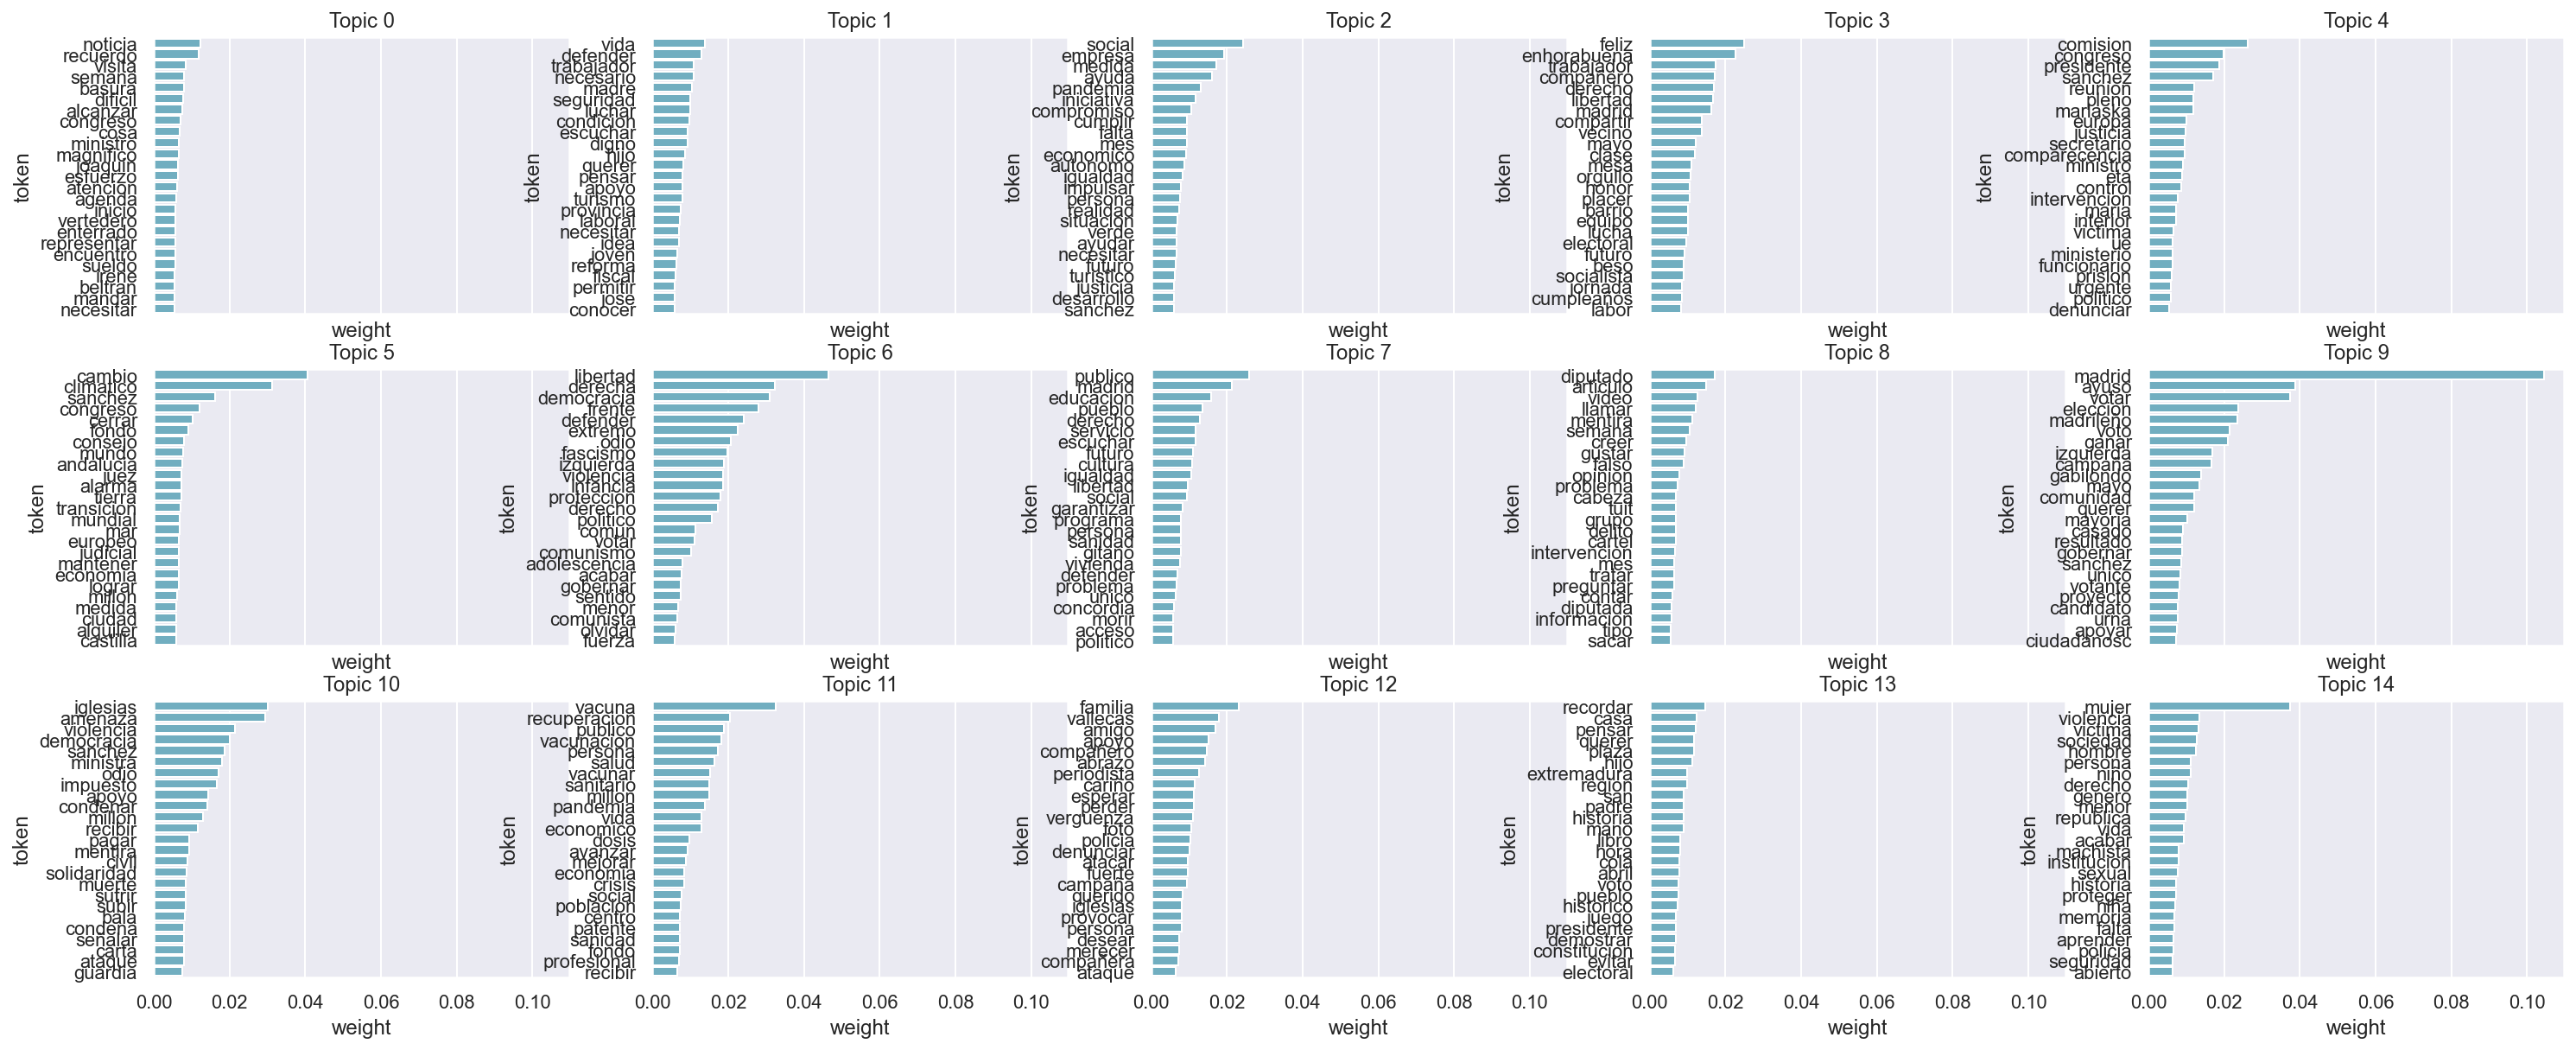

In [37]:
ldamallet = compute_lda(tweets_corpus_bow, filtered_dict, num_topics=15)
topn = 25
rows, cols = 3, 5
fig, axes = plt.subplots(rows, cols, figsize=(25, 10), sharex=True)

for i in range(rows):
    for j in range(cols):
        df = pd.DataFrame(ldamallet.show_topic(j + cols*(i%rows), topn=topn), columns=['token','weight'])
        sns.barplot(x='weight', y='token', data=df, color='c', orient='h', ax=axes[i][j])
        axes[i][j].set_title(f'Topic {j + cols*(i%rows)}')

plt.show()

In [41]:
from gensim.models.wrappers.ldamallet import malletmodel2ldamodel
import pyLDAvis
from pyLDAvis.gensim_models import prepare

# ldamallet = LdaMallet(mallet_path, corpus=mycorpus_bow, num_topics=15, id2word=D, alpha=5, iterations=1000)
ldamallet = compute_lda(tweets_corpus_bow, filtered_dict, num_topics=11, iterations=1000)
  

c:\users\manun\documents\mis proyectos\nlp-with-spanish-politicians-tweets\venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [42]:
ldagensim = malletmodel2ldamodel(ldamallet)
vis_data = prepare(ldagensim, tweets_corpus_bow, filtered_dict)
pyLDAvis.display(vis_data)

c:\users\manun\documents\mis proyectos\nlp-with-spanish-politicians-tweets\venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [35]:
# tpc_descriptions = []

# for ntpc in range(15):
#     print(ldagensim.show_topic(ntpc, topn=20))
#     desc = input('Introduce a label for topic ' + str(ntpc) + ': ')
#     tpc_descriptions.append(desc)

c:\users\manun\documents\mis proyectos\nlp-with-spanish-politicians-tweets\venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [36]:
# print(list(ldamallet.load_document_topics()))
# print(len(list(ldamallet.load_document_topics())))

"""
rec = []
for topic in ldamallet.load_document_topics():
    rec.append([value[1] for value in topic])
       
df = pd.DataFrame(rec)

print(len(df), len(data))


df['Likes'] = data.sort_index()["Likes"].to_list()
df['Retweets'] = data.sort_index()["Retweets"].to_list()
df["Party"] = data.sort_index()["Party"].to_list()
df
"""

c:\users\manun\documents\mis proyectos\nlp-with-spanish-politicians-tweets\venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'\nrec = []\nfor topic in ldamallet.load_document_topics():\n    rec.append([value[1] for value in topic])\n       \ndf = pd.DataFrame(rec)\n\nprint(len(df), len(data))\n\n\ndf[\'Likes\'] = data.sort_index()["Likes"].to_list()\ndf[\'Retweets\'] = data.sort_index()["Retweets"].to_list()\ndf["Party"] = data.sort_index()["Party"].to_list()\ndf\n'